In [1]:
from collections import defaultdict, OrderedDict
import math

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ks_2samp, entropy

import sim_lib.util as util
import sim_lib.attr_lib.util as alu
from sim_lib.attr_lib.formation import *
import sim_lib.attr_lib.vis as vis

In [2]:
# Setup
filepath = 'data/satiation_removal_comparisons.csv'

md_cols = ['attr_func', 'struct_func', 'seed', 'theta', 'agg_func']
simulations_df = pd.read_csv(filepath, index_col=0)
metric_cols = [ col for col in simulations_df.columns if col not in md_cols ]

for metric in metric_cols:
    simulations_df[metric] = simulations_df[metric].apply(lambda x : [ float(v) for v in x[1:-1].split(', ') ])
simulations_df['sum_util'] = simulations_df.apply(lambda r: np.add(r['attr_util'], r['struct_util']), axis=1)
simulations_df['sum_util_delta'] = simulations_df.apply(lambda r: np.add(r['attr_delta'], r['struct_delta']), axis=1)
metric_cols = [ col for col in simulations_df.columns if col not in md_cols ]

In [3]:
def plot_grid_values(sim_df):
    attr_strats = pd.unique(sim_df['attr_func'])
    struct_strats = pd.unique(sim_df['struct_func'])
    seed_types = pd.unique(sim_df['seed'])
    agg_types = pd.unique(sim_df['agg_func'])

    inner_loop = [ (ast, sst, agt) for ast in attr_strats for sst in struct_strats for agt in agg_types ]
    
    for seed in seed_types:
        
        # Split into different grids
        print('Initial graph seed:', seed)
        seed_fig = plt.figure(figsize=(20, 20))
        plt_idx = 1
        for metric in metric_cols:
            metric_subplots = []
            max_yval = -1
            min_yval = np.infty
            for (ast, sst, agt) in inner_loop:
                metric_cnt = len(sim_df.columns) - len(md_cols)
                strategies_cnt = len(attr_strats) * len(struct_strats) * len(agg_types)

                sim_metric_vals = sim_df.loc[
                        sim_df['attr_func'] == ast].loc[
                        sim_df['struct_func'] == sst].loc[
                        sim_df['seed'] == seed].loc[
                        sim_df['agg_func'] == agt]

                seed_ax = seed_fig.add_subplot(metric_cnt, strategies_cnt, plt_idx)
                plt_idx += 1
                seed_ax.set_title(f'{ast} {sst} {agt}; {metric}')

                metric_vals = sim_metric_vals[['theta', metric]]
                theta_vals = np.sort(pd.unique(sim_metric_vals['theta']))
                alpha_vals = np.linspace(0, 1, num=len(theta_vals) + 1)[1:]
                for theta, alpha in zip(theta_vals, alpha_vals):
                    y_vals = metric_vals.loc[metric_vals['theta'] == theta][metric].iloc[0]
                    x_vals = list(range(1, len(y_vals) + 1))
                    seed_ax.plot(x_vals, y_vals, color='orange', alpha=alpha, label=f'theta {theta}')

                    max_yval = max(y_vals) if max(y_vals) > max_yval else max_yval
                    min_yval = min(y_vals) if min(y_vals) < min_yval else min_yval
                    metric_subplots.append(seed_ax)
                        
            for ma in metric_subplots:
                ma.set_ylim([min_yval - 0.05, max_yval + 0.05])                        
                
        seed_fig.tight_layout()

        plt.xlabel('Iteration')
        plt.legend(loc='upper right')
        plt.show()

Initial graph seed: trivial


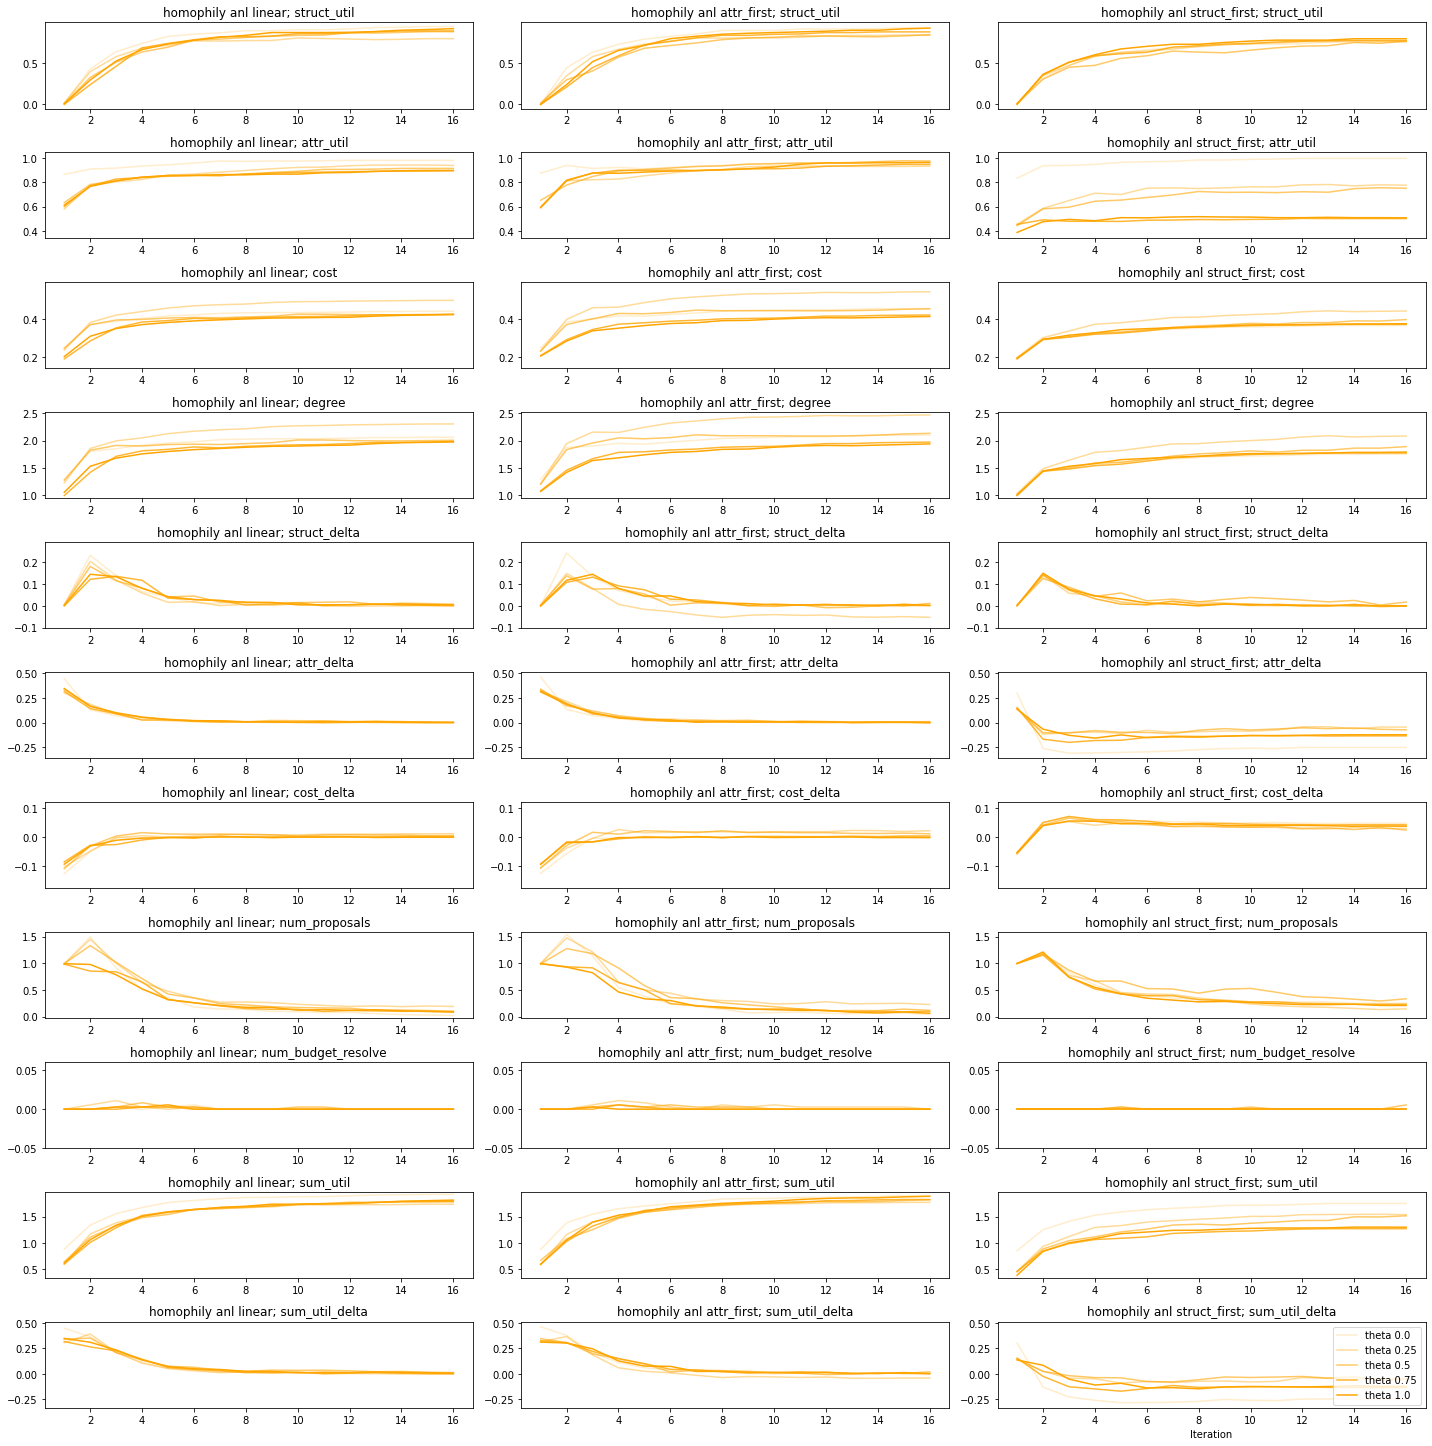

In [4]:
plot_grid_values(simulations_df)